In [3]:
from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 3.6.0 which is incompatible.
tensorflow-macos 2.12.0 requires tensorboard<2.13,>=2.12, but you have tensorboard 2.16.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.1/22.1 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, LayerNormalization, Input, Activation, Lambda, Bidirectional, Add, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import json
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa


folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")
random_state_value = None

NotFoundError: dlopen(/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Symbol not found: __ZN10tensorflow16TensorShapeProtoC1ERKS0_
  Referenced from: <C62E0AB4-567E-3E14-8F96-9F07A746C4DC> /usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Expected in:     <F6E5CDA9-FFF3-30B8-91C3-FA301C0C89C3> /usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so

In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df


def add_solar_features(df):
    # Calculate solar angle
    df['solar_angle'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Interactions between relevant features
    df['cloud_temp_interaction'] = df['cloudcover'] * df['temp']
    df['visibility_cloud_interaction'] = df['visibility'] * (100 - df['cloudcover'])

    # Derived features
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_gradient'] = df['temp'] - df['tempmin']

    return df


def add_solar_specific_features(df):
    # Solar angle and day length calculations
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = 12 - df['hour']
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Feature interactions
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']

    # Extended window rolling features
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()

    return df


def add_uv_specific_features(df):
    # Solar zenith angle calculation
    lat = df['latitude'].iloc[0]  # assuming constant latitude for the dataset
    df['solar_zenith'] = 90 - np.arcsin(
        np.sin(np.radians(lat)) * np.sin(df['solar_elevation']) +
        np.cos(np.radians(lat)) * np.cos(df['solar_elevation']) * np.cos(df['hour'] * 15)
    ).degrees

    # UV peak hours indicator (10:00-16:00)
    df['is_uv_peak_hours'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)

    # Atmospheric attenuation factor
    df['atmospheric_attenuation'] = (100 - df['cloudcover']) * (df['visibility'] / 100) * (1 - df['humidity'] / 200)

    # Seasonal UV factor
    df['uv_seasonal_factor'] = np.where(df['season_Summer'], 1.0,
                                        np.where(df['season_Spring'], 0.7,
                                                 np.where(df['season_Autumn'], 0.5, 0.3)))

    # Solar elevation and atmospheric transparency interaction
    df['solar_clarity_index'] = df['solar_elevation'] * df['atmospheric_attenuation'] / 100

    # UV-specific rolling features
    df['clarity_rolling_3h'] = df['atmospheric_attenuation'].rolling(window=3).mean()
    df['temp_uv_interaction'] = df['temp'] * df['solar_clarity_index']

    return df


def add_advanced_features(df):
    # Apply existing feature engineering
    df = add_time_features(df)
    df = add_solar_features(df)
    df = add_solar_specific_features(df)
    df = add_uv_specific_features(df)

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=['season', 'time_period'])

    # Weather variable interactions
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']

    # Solar radiation derived features
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['day_length'] = np.sin(df['day_of_year_sin']) * 12 + 12  # day length approximation

    # Lag features
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    # Rolling means
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()

    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100

    # Extreme conditions indicator
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) &
                                (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    # Atmospheric transparency composite feature
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    # Transitional seasons indicator
    df['is_transition_season'] = ((df['season_Spring'] | df['season_Autumn'])).astype(int)

    # Solar angle and normalized cloud cover interaction
    df['solar_cloud_effect'] = df['solar_elevation'] * (100 - df['cloudcover']) / 100

    # Atmospheric stability indicator
    df['pressure_stability'] = df.groupby(df.index.date if isinstance(df.index, pd.DatetimeIndex)
                                          else df.index.to_series().dt.date)['pressure'].transform(
        lambda x: x.std()
    ).fillna(0)

    return df


def prepare_advanced_data(df):
    """
    Prepares data for UV index prediction model with advanced feature engineering
    and optimized preprocessing.

    Args:
        df: DataFrame with meteorological data

    Returns:
        tuple: (X_train_scaled, X_test_scaled, y_train, y_test, scaler, final_features, X_to_predict_scaled)
    """
    # Apply feature engineering functions
    df = add_advanced_features(df)

    # Optimized feature selection for UV index
    selected_features = {
        # Primary meteorological features (high correlation with UV)
        'atmospheric': [
            'temp', 'humidity', 'cloudcover', 'visibility',
            'clear_sky_index', 'atmospheric_transparency'
        ],

        # Essential cyclic temporal features
        'temporal': [
            'hour_sin', 'hour_cos',
            'day_of_year_sin', 'day_of_year_cos'
        ],

        # Critical solar features for UV
        'solar': [
            'solar_angle', 'solar_elevation',
            'day_length', 'solar_noon',
            'solar_cloud_effect'
        ],

        # Key interactions
        'interactions': [
            'cloud_temp_interaction',
            'visibility_cloud_interaction',
            'temp_humidity_interaction',
            'solar_clarity_index'
        ],

        # Significant rolling features
        'rolling': [
            'cloud_rolling_12h',
            'temp_rolling_mean_6h',
            'atmospheric_stability'
        ]
    }

    # Flatten feature list
    base_features = [item for sublist in selected_features.values() for item in sublist]

    # Add categorical features (one-hot encoded)
    categorical_columns = [col for col in df.columns if col.startswith(('season_', 'time_period_'))]
    final_features = base_features + categorical_columns

    # Temporal preprocessing
    df = df.sort_values('datetime')
    df.set_index('datetime', inplace=True)

    # Advanced interpolation for missing values
    for column in final_features:
        if column in df.columns:
            if df[column].isnull().any():
                if column in selected_features['rolling']:
                    df[column] = df[column].fillna(method='ffill').fillna(method='bfill')
                else:
                    df[column] = df[column].interpolate(method='time', limit_direction='both')

    # Temporal data split
    data_after_2010 = df[df.index.year >= 2010].copy()
    data_before_2010 = df[df.index.year < 2010].copy()

    print(f"\nTemporal distribution of data:")
    print(f"Records after 2010: {len(data_after_2010):,}")
    print(f"Records before 2010: {len(data_before_2010):,}")

    # Feature and target preparation
    X = data_after_2010[final_features]
    y = data_after_2010['uvindex']
    X_to_predict = data_before_2010[final_features]

    # Data validation
    if X.isnull().any().any() or y.isnull().any():
        print("\nWarning: Found missing values after preprocessing")
        print("Features with missing values:", X.columns[X.isnull().any()].tolist())
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())

    # Stratified data split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state_value,
        stratify=pd.qcut(y, q=5, duplicates='drop', labels=False)
    )

    # Robust feature scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_to_predict_scaled = scaler.transform(X_to_predict)

    # Final validation
    assert not np.isnan(X_train_scaled).any(), "Found NaN in X_train_scaled"
    assert not np.isnan(X_test_scaled).any(), "Found NaN in X_test_scaled"
    assert not np.isnan(X_to_predict_scaled).any(), "Found NaN in X_to_predict_scaled"

    # Print feature information
    print("\nNumber of features used:", len(final_features))
    print("\nFeature categories:")
    for category, features in selected_features.items():
        print(f"{category}: {len(features)} features")
    print(f"Categorical: {len(categorical_columns)} features")

    return (X_train_scaled, X_test_scaled, y_train, y_test,
            scaler, final_features, X_to_predict_scaled)


def create_sequence_data(X, sequence_length=24):
    """
    Converts data into sequences for LSTM input
    sequence_length represents how many previous hours to consider
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):
    # Use existing data preparation
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convert data to sequences
    sequence_length = 24  # 24 hours of historical data

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adjust y by removing the first (sequence_length-1) elements
    y_train = y_train[sequence_length - 1:]
    y_test = y_test[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq

In [8]:
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01,
                               survival_probability=0.8, return_sequences=True):
    """LSTM layer with stochastic depth"""
    residual = x

    # Main path
    x = Bidirectional(LSTM(units, return_sequences=return_sequences,
                           kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Adjust residual dimension if needed
    if return_sequences:
        if int(residual.shape[-1]) != 2 * units:
            residual = Conv1D(2 * units, 1)(residual)

    x = tfa.layers.StochasticDepth(survival_probability)([x, residual])

    return x


def attention_block(x, units, num_heads=8, survival_probability=0.8):
    """
    Attention block with stochastic depth.

    Args:
        x: input tensor
        units: number of units for the attention
        num_heads: number of attention heads
        survival_probability: probability of the layer being kept during training
    """
    # Compute self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)

    # Apply stochastic depth to the attention path
    x = tfa.layers.StochasticDepth(survival_probability)([attention, x])
    x = LayerNormalization()(x)

    # Optional: FFN block with stochastic depth
    ffn = Dense(units * 4, activation='swish')(x)
    ffn = Dense(units)(ffn)
    x = tfa.layers.StochasticDepth(survival_probability)([ffn, x])
    x = LayerNormalization()(x)

    return x


def create_uv_index_model(input_shape, folder_name, l2_lambda=0.005):
    inputs = Input(shape=input_shape)

    # Progressive survival probabilities
    survival_probs = [0.9, 0.8, 0.7]
    attention_survival_probs = [0.85, 0.75, 0.65]

    # First LSTM block with stochastic depth
    x = create_residual_lstm_layer(
        inputs, 128, dropout_rate=0.4,
        l2_reg=l2_lambda,
        survival_probability=survival_probs[0],
        return_sequences=True
    )
    x = attention_block(x, 128, num_heads=8,
                        survival_probability=attention_survival_probs[0])

    # Second LSTM block with stochastic depth
    x = create_residual_lstm_layer(
        x, 64, dropout_rate=0.3,
        l2_reg=l2_lambda,
        survival_probability=survival_probs[1],
        return_sequences=True
    )
    x = attention_block(x, 64, num_heads=8,
                        survival_probability=attention_survival_probs[1])

    # Third LSTM block with stochastic depth
    x = create_residual_lstm_layer(
        x, 32, dropout_rate=0.2,
        l2_reg=l2_lambda,
        survival_probability=survival_probs[2],
        return_sequences=True
    )
    x = attention_block(x, 32, num_heads=8,
                        survival_probability=attention_survival_probs[2])

    # Global attention with stochastic depth
    temporal_attention = MultiHeadAttention(num_heads=16, key_dim=32)(x, x)
    x = tfa.layers.StochasticDepth(survival_probability=0.8)([temporal_attention, x])
    x = LayerNormalization()(x)

    # Pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers with stochastic depth
    dense = Dense(32, activation='swish',
                  kernel_regularizer=regularizers.l2(l2_lambda))(x)
    dense = BatchNormalization()(dense)
    skip = Dense(32, activation='linear')(x)
    x = tfa.layers.StochasticDepth(survival_probability=0.9)([dense, skip])

    # Final dense layer
    x = Dense(16, activation='swish',
              kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Dense(1)(x)
    outputs = Lambda(lambda x: tf.clip_by_value(x, 0, 11))(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="UvModel")

    # Cosine decay with warmup
    initial_learning_rate = 0.001
    decay_steps = 10000

    cosine_decay = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate,
        decay_steps,
        t_mul=2.0,
        m_mul=0.9,
        alpha=0.1
    )

    optimizer = AdamW(
        learning_rate=cosine_decay,
        weight_decay=0.01
    )

    # UV-specific loss
    def uv_aware_loss(y_true, y_pred):
        huber_loss = tf.keras.losses.Huber()(y_true, y_pred)

        # Higher weight for UV peak hours
        time_of_day = tf.cast(tf.math.floormod(tf.range(tf.shape(y_true)[0]), 24),
                              tf.float32)
        peak_hours_weight = tf.where(
            tf.logical_and(time_of_day >= 10, time_of_day <= 16),
            1.5,
            1.0
        )

        # Higher weight for high UV values
        high_uv_weight = tf.where(
            y_true >= 8,
            1.3,
            1.0
        )

        return huber_loss * peak_hours_weight * high_uv_weight

    model.compile(
        optimizer=optimizer,
        loss=uv_aware_loss,
        metrics=[
            'mae',
            'mse',
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    model.summary()

    plot_model(model,
               to_file=f'{folder_name}_model_architecture.png',
               show_shapes=True,
               show_layer_names=True,
               dpi=150,
               show_layer_activations=True)

    return model


def evaluate_uv_predictions(y_true, y_pred, folder_name=None):
    """
    Comprehensive evaluation of UV index predictions with detailed analysis and visualizations.

    Parameters:
    -----------
    y_true : array-like
        Actual UV index values
    y_pred : array-like
        Predicted UV index values
    folder_name : str, optional
        Folder to save analysis plots

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """
    import os
    from datetime import datetime
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

    # Data preprocessing
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    # Rounding and clipping predictions
    y_pred_rounded = np.round(y_pred * 2) / 2  # Round to nearest 0.5
    y_pred_clipped = np.clip(y_pred_rounded, 0, 11)

    # Calculate errors
    errors = y_pred - y_true
    errors_rounded = y_pred_clipped - y_true

    # Function to determine UV risk level
    def get_uv_risk_level(values):
        levels = np.full_like(values, 'Low', dtype=object)
        levels[(values > 2) & (values <= 5)] = 'Moderate'
        levels[(values > 5) & (values <= 7)] = 'High'
        levels[(values > 7) & (values <= 10)] = 'Very High'
        levels[values > 10] = 'Extreme'
        return levels

    # Calculate basic metrics
    metrics = {
        'raw': {
            'mae': mean_absolute_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'r2': r2_score(y_true, y_pred),
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'median_error': np.median(errors),
            'p95_abs_error': np.percentile(np.abs(errors), 95)
        },
        'rounded': {
            'mae': mean_absolute_error(y_true, y_pred_clipped),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred_clipped)),
            'r2': r2_score(y_true, y_pred_clipped)
        }
    }

    # Calculate accuracies for different margins
    for data_type, errors_data in [('raw', errors), ('rounded', errors_rounded)]:
        metrics[data_type].update({
            'within_05': np.mean(np.abs(errors_data) <= 0.5) * 100,
            'within_1': np.mean(np.abs(errors_data) <= 1.0) * 100,
            'within_15': np.mean(np.abs(errors_data) <= 1.5) * 100,
            'within_2': np.mean(np.abs(errors_data) <= 2.0) * 100
        })

    # Analysis by UV risk level
    y_true_risk = get_uv_risk_level(y_true)
    y_pred_risk = get_uv_risk_level(y_pred_clipped)

    # Calculate confusion matrix
    risk_levels = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']
    cm = confusion_matrix(y_true_risk, y_pred_risk)
    cm_df = pd.DataFrame(cm, columns=risk_levels, index=risk_levels)

    # Analysis by UV range
    uv_ranges = [
        (0, 2, 'Low'),
        (2, 5, 'Moderate'),
        (5, 7, 'High'),
        (7, 10, 'Very High'),
        (10, 11, 'Extreme')
    ]

    range_analysis = {}
    for low, high, label in uv_ranges:
        mask = (y_true >= low) & (y_true < high)
        if mask.any():
            range_analysis[label] = {
                'mae': mean_absolute_error(y_true[mask], y_pred[mask]),
                'count': np.sum(mask),
                'accuracy_within_05': np.mean(np.abs(errors[mask]) <= 0.5) * 100,
                'accuracy_within_1': np.mean(np.abs(errors[mask]) <= 1.0) * 100
            }

    # Visualizations
    if folder_name is not None:
        try:
            os.makedirs(folder_name, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

            # Main figure with 4 subplots
            fig = plt.figure(figsize=(20, 15))

            # 1. Error distribution
            plt.subplot(2, 2, 1)
            plt.hist(errors, bins=50, alpha=0.7)
            plt.title('Prediction Error Distribution')
            plt.xlabel('Error')
            plt.ylabel('Frequency')

            # 2. Actual vs Predicted scatter plot
            plt.subplot(2, 2, 2)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([0, 11], [0, 11], 'r--', lw=2)
            plt.title('Actual vs Predicted Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')

            # 3. Errors vs Actual Values
            plt.subplot(2, 2, 3)
            plt.scatter(y_true, errors, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.title('Errors vs Actual Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Error')

            # 4. Accuracy and MAE by range
            ax = plt.subplot(2, 2, 4)
            x_labels = [f"{label}\n({low}-{high})" for low, high, label in uv_ranges]
            accuracies = [range_analysis[label]['accuracy_within_05']
                          for _, _, label in uv_ranges if label in range_analysis]
            mae_values = [range_analysis[label]['mae']
                          for _, _, label in uv_ranges if label in range_analysis]

            bars = plt.bar(x_labels, accuracies, alpha=0.6)
            plt.ylabel('Accuracy within ±0.5 (%)')
            plt.title('Accuracy and MAE by UV Range')

            # Add MAE as line
            ax2 = ax.twinx()
            ax2.plot(x_labels, mae_values, 'r-o', label='MAE')
            ax2.set_ylabel('MAE', color='red')

            plt.tight_layout()

            # Save main figure
            main_plot_path = os.path.join(folder_name, f'uv_analysis_{timestamp}.png')
            plt.savefig(main_plot_path, dpi=300, bbox_inches='tight')

            # Confusion matrix as separate plot
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for UV Risk Levels')

            conf_matrix_path = os.path.join(folder_name, f'confusion_matrix_{timestamp}.png')
            plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')

            plt.close('all')

        except Exception as e:
            print(f"\nError saving plots: {str(e)}")

    # Print detailed report
    print("\nUV Index Prediction Analysis:")
    print("\nRaw Metrics:")
    for key, value in metrics['raw'].items():
        print(f"{key}: {value:.3f}")

    print("\nRounded Metrics:")
    for key, value in metrics['rounded'].items():
        print(f"{key}: {value:.3f}")

    print("\nAnalysis by UV Range:")
    for label, stats in range_analysis.items():
        print(f"\n{label}:")
        for key, value in stats.items():
            print(f"  {key}: {value:.3f}")

    print("\nConfusion Matrix:")
    print(cm_df)

    # Add range analysis and confusion matrix to metrics dictionary
    metrics.update({
        'range_analysis': range_analysis,
        'confusion_matrix': cm_df.to_dict(),
        'plot_paths': {
            'main_analysis': main_plot_path if folder_name else None,
            'confusion_matrix': conf_matrix_path if folder_name else None
        }
    })

    return metrics

def plot_training_history(history, folder_name=None):
    """
    Visualize and save the loss and metrics plots during training

    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        The history object returned by model training
    folder_name : str
        Folder where to save the plot
    """
    import os

    try:
        # Create the figure
        plt.figure(figsize=(12, 4))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # MAE Plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        if folder_name is not None:
            os.makedirs(folder_name, exist_ok=True)
            # Generate filename with timestamp
            filename = os.path.join(folder_name, 'training_history.png')

            # Save the figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nTraining history plot saved as: {filename}")

        # Also save numerical data in CSV format
        history_df = pd.DataFrame({
            'epoch': range(1, len(history.history['loss']) + 1),
            'training_loss': history.history['loss'],
            'validation_loss': history.history['val_loss'],
            'training_mae': history.history['mae'],
            'validation_mae': history.history['val_mae']
        })

        if folder_name is not None:
            csv_filename = os.path.join(folder_name, 'training_history.csv')
            history_df.to_csv(csv_filename, index=False)
            print(f"Training history data saved as: {csv_filename}")

        # Calculate and save final statistics
        final_stats = {
            'final_training_loss': history.history['loss'][-1],
            'final_validation_loss': history.history['val_loss'][-1],
            'final_training_mae': history.history['mae'][-1],
            'final_validation_mae': history.history['val_mae'][-1],
            'best_validation_loss': min(history.history['val_loss']),
            'best_validation_mae': min(history.history['val_mae']),
            'epochs': len(history.history['loss']),
        }

        if folder_name is not None:
            # Save statistics in JSON format
            stats_filename = os.path.join(folder_name, 'training_stats.json')
            with open(stats_filename, 'w') as f:
                json.dump(final_stats, f, indent=4)
            print(f"Final statistics saved as: {stats_filename}")

        # Print main statistics
        print("\nFinal training statistics:")
        print(f"Final Loss (train/val): {final_stats['final_training_loss']:.4f}/{final_stats['final_validation_loss']:.4f}")
        print(f"Final MAE (train/val): {final_stats['final_training_mae']:.4f}/{final_stats['final_validation_mae']:.4f}")
        print(f"Best validation loss: {final_stats['best_validation_loss']:.4f}")
        print(f"Best validation MAE: {final_stats['best_validation_mae']:.4f}")

        plt.show()

    except Exception as e:
        print(f"\nError during plot creation or saving: {str(e)}")


def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='uv_index'):
    """
    Advanced training function for the hybrid UV index model with detailed monitoring
    and training management.

    Parameters:
    -----------
    model : keras.Model
        The compiled hybrid model
    X_train : numpy.ndarray
        Training data
    y_train : numpy.ndarray
        Training targets
    X_test : numpy.ndarray
        Validation data
    y_test : numpy.ndarray
        Validation targets
    epochs : int, optional
        Maximum number of training epochs
    batch_size : int, optional
        Batch size

    Returns:
    --------
    history : keras.callbacks.History
        Training history with all metrics
    """

    # Advanced callbacks for training
    callbacks = [
        # Advanced Early Stopping
        EarlyStopping(
            monitor='mae',
            patience=15,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-6
        ),
        ReduceLROnPlateau(
            monitor='mae',
            factor=0.05,
            patience=3,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=2,
            min_lr=1e-7
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=1,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_uv_model.h5',
            monitor='mae',
            save_best_only=True,
            mode='min'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs_{folder_name}',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(
                f"\nEpoch {epoch + 1}: Out of range predictions: "
                f"{np.sum((model.predict(X_test) < 0) | (model.predict(X_test) > 11))}"
            ) if epoch % 20 == 0 else None
        )
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False,
            validation_freq=1,
        )

        # Post-training analysis
        print("\nTraining completed successfully!")

        # Final evaluation on test set
        test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nFinal metrics on test set:")
        print(f"Loss: {test_loss:.4f}")
        print(f"MAE: {test_mae:.4f}")
        print(f"MSE: {test_mse:.4f}")

        # Prediction analysis
        predictions = model.predict(X_test)
        out_of_range = np.sum((predictions < 0) | (predictions > 11))
        print(f"\nOut of range predictions: {out_of_range} ({out_of_range / len(predictions) * 100:.2f}%)")

        plot_training_history(history, folder_name=folder_name)

        return history

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

    finally:
        # Memory cleanup
        tf.keras.backend.clear_session()


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integrate UV index predictions into the original dataset for pre-2010 data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original dataset
    predictions : numpy.ndarray
        Array of UV index predictions
    sequence_length : int
        Sequence length used for predictions

    Returns:
    --------
    pandas.DataFrame
        Updated dataset with UV index predictions
    """
    # Convert datetime to datetime format if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identify pre-2010 rows
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Create temporary DataFrame with predictions
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'uvindex_predicted': predictions.flatten()
    })

    # Merge with original dataset
    df = df.merge(predictions_df, on='datetime', how='left')

    # Update uvindex column where missing
    df['uvindex'] = df['uvindex'].fillna(df['uvindex_predicted'])

    # Remove temporary column
    df = df.drop('uvindex_predicted', axis=1)

    print(f"Added {len(predictions)} predictions to dataset")
    print(f"Rows with UV index after integration: {df['uvindex'].notna().sum()}")

    return df


def train_uvindex_bounded_model(df):
    """
    Training of the model with specific constraints for UV index
    """
    print("Initializing UV index model training...")

    try:
        # Data preparation
        print("\n1. Preparing data...")
        X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq = prepare_hybrid_data(df)

        print(f"Training data shape: {X_train_seq.shape}")
        print(f"Test data shape: {X_test_seq.shape}")

        # Data quality verification
        if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
            raise ValueError("Found NaN values in training data")

        # Model creation
        print("\n2. Creating model...")
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        model = create_uv_index_model(input_shape, folder_name)

        print("\n4. Starting training...")
        history = train_hybrid_model(
            model=model,
            X_train=X_train_seq,
            y_train=y_train,
            X_test=X_test_seq,
            y_test=y_test,
            epochs=100,
            batch_size=128,
            folder_name=folder_name
        )

        print("\n5. Generating predictions...")
        predictions = model.predict(X_test_seq)
        predictions = np.clip(predictions, 0, 11)

        print("\n6. Model evaluation...")
        metrics = evaluate_uv_predictions(y_test, predictions, folder_name=folder_name)

        # Creating results dictionary
        training_results = {
            'model_params': {
                'input_shape': input_shape,
                'n_features': len(features),
                'sequence_length': X_train_seq.shape[1]
            },
            'training_params': {
                'batch_size': 32,
                'total_epochs': len(history.history['loss']),
                'best_epoch': np.argmin(history.history['val_loss']) + 1,
            },
            'performance_metrics': {
                'final_loss': float(history.history['val_loss'][-1]),
                'final_mae': float(history.history['val_mae'][-1]),
                'best_val_loss': float(min(history.history['val_loss'])),
                'out_of_range_predictions': int(np.sum((predictions < 0) | (predictions > 11)))
            }
        }

        print("\n7. Predicting missing data results...")
        to_predict_predictions = model.predict(X_to_predict_seq)
        to_predict_predictions = np.clip(to_predict_predictions, 0, 11)

        print("\n8. Integrating predictions into original dataset...")
        df_updated = integrate_predictions(df.copy(), to_predict_predictions)

        df_updated.to_parquet('../../sources/weather_data_uvindex.parquet')

        # Add prediction statistics to training_results
        training_results['prediction_stats'] = {
            'n_predictions_added': len(to_predict_predictions),
            'mean_predicted_uv': float(to_predict_predictions.mean()),
            'min_predicted_uv': float(to_predict_predictions.min()),
            'max_predicted_uv': float(to_predict_predictions.max()),
        }

        print("\nTraining completed successfully!")

        return model, scaler, features, history, predictions, y_test, metrics, training_results

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

    finally:
        # Memory cleanup
        tf.keras.backend.clear_session()

Inizializzazione del training del modello UV index...

1. Preparazione dei dati...

Numero di record dopo 2010: 129777
Numero di record prima 2010: 227902
Shape dei dati di training: (64865, 24, 33)
Shape dei dati di test: (64866, 24, 33)

2. Creazione del modello...


2024-11-10 22:48:30.467084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:e1:00.0, compute capability: 8.6
2024-11-10 22:48:30.995563: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "UvModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 33)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 24, 256)              165888    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 layer_normalization (Layer  (None, 24, 256)              512       ['bidirectional[0][0]']       
 Normalization)                                                                                   
                                                                                            

2024-11-10 22:48:44.916189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-10 22:48:47.364274: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb501567b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-10 22:48:47.364334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-10 22:48:47.375943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-10 22:48:47.576847: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 [==============================] - ETA: 0s - loss: 3.0211 - mae: 0.8732 - mse: 2.6901

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2028/2028 [==============================] - 22s 11ms/step

Epoch 1: Predizioni fuori range: 0
507/507 [==============================] - 95s 149ms/step - loss: 3.0211 - mae: 0.8732 - mse: 2.6901 - val_loss: 1.1114 - val_mae: 0.5132 - val_mse: 0.8839 - lr: 5.0000e-04
Epoch 2/100
507/507 [==============================] - 23s 46ms/step - loss: 0.8217 - mae: 0.5744 - mse: 1.1119 - val_loss: 0.5794 - val_mae: 0.5285 - val_mse: 0.8990 - lr: 5.0000e-04
Epoch 3/100
507/507 [==============================] - 23s 45ms/step - loss: 0.5241 - mae: 0.5406 - mse: 0.9968 - val_loss: 0.4411 - val_mae: 0.4995 - val_mse: 0.8515 - lr: 5.0000e-04
Epoch 4/100
507/507 [==============================] - 23s 45ms/step - loss: 0.4490 - mae: 0.5363 - mse: 0.9738 - val_loss: 0.3752 - val_mae: 0.4606 - val_mse: 0.7784 - lr: 5.0000e-04
Epoch 5/100
507/507 [==============================] - 23s 45ms/step - loss: 0.4127 - mae: 0.5218 - mse: 0.9290 - val_loss: 0.3470 - val_mae: 0.4698 - val_mse: 0.7271 - lr: 5.0000e

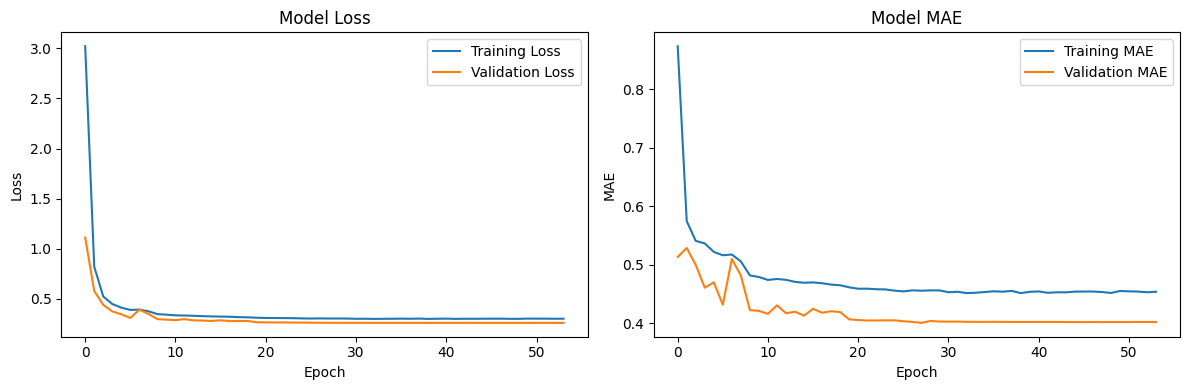


5. Generazione delle predizioni...
2028/2028 [==============================] - 23s 11ms/step

6. Valutazione del modello...

UV Index Prediction Metrics:
MAE: 0.384
RMSE: 0.809
R² Score: 0.911
Exact Match Accuracy: 0.331
±1 Accuracy: 0.458
±2 Accuracy: 0.566

UV Level Confusion Matrix:
Predicted  High    Low  Moderate  Very High
Actual                                     
High       3134     11      1252        481
Low         129  43324      1888         19
Moderate   1208   1663      7320        152
Very High  1188      1        78       3018

7. Visualizzazione risultati...


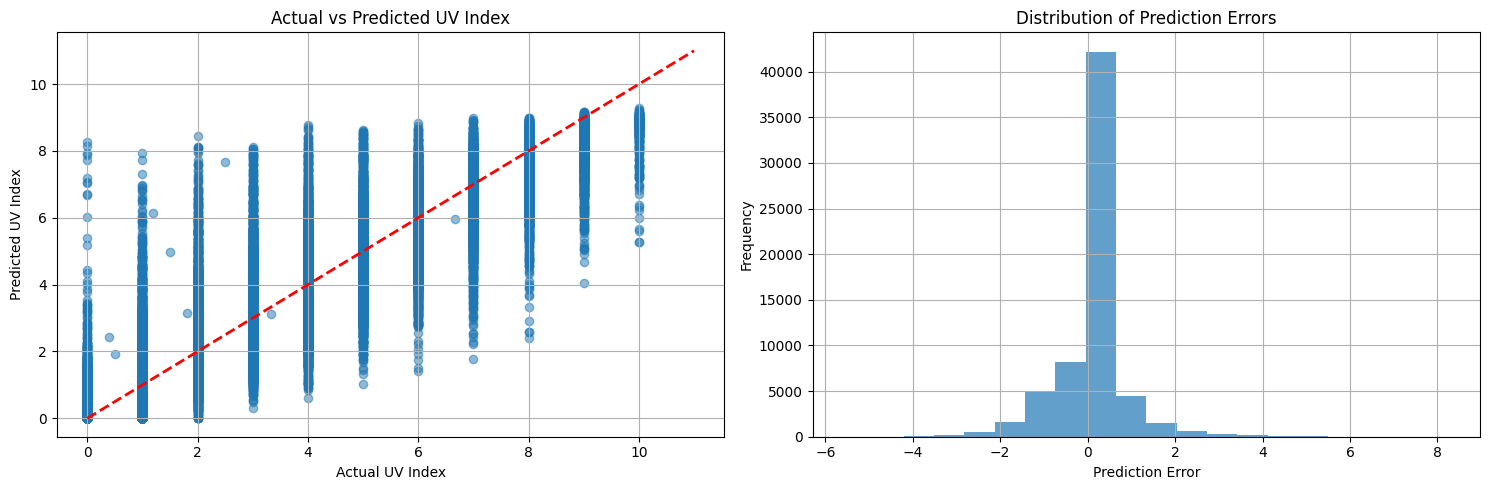


8. Predizione dei dati mancanti risultati...
7122/7122 [==============================] - 78s 11ms/step

9. Integrazione delle predizioni nel dataset originale...
Aggiunte 227879 predizioni al dataset
Righe con UV index dopo l'integrazione: 357615

Training completato con successo!


In [9]:
df = pd.read_parquet('../../sources/weather_data.parquet')

model, scaler, features, history, predictions, y_test, metrics, training_results = train_uvindex_bounded_model(df)

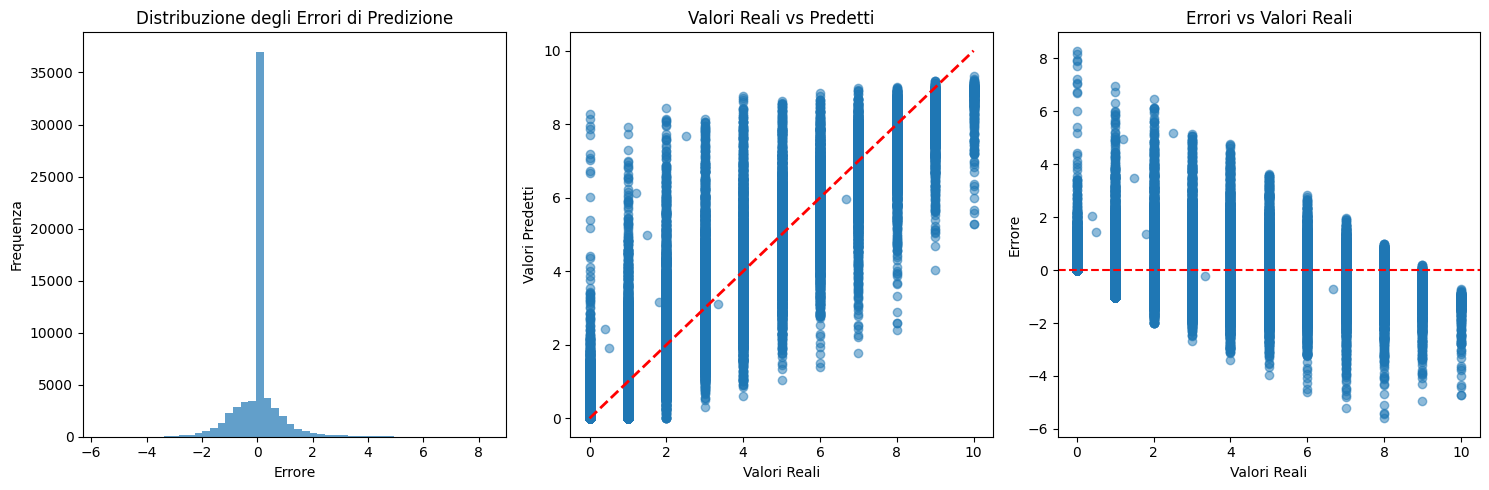


Statistiche degli errori:
MAE: 0.4021
MSE: 0.6128
RMSE: 0.7828
Media errori: 0.0062
Std errori: 0.7828
Predizioni entro ±0.5: 71.1%
Predizioni entro ±1.0: 86.1%
Predizioni entro ±1.5: 93.2%
Predizioni entro ±2.0: 96.5%


In [11]:
def plot_error_analysis(y_true, y_pred, folder_name=None):
    """
    Function to visualize prediction error analysis

    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    folder_name : str, optional
        Folder to save plots. If None, plots are not saved.
    """
    import os
    from datetime import datetime

    # Convert to 1D numpy array if necessary
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calculate errors
    errors = y_pred - y_true

    # Create main figure
    fig = plt.figure(figsize=(15, 5))

    # Plot 1: Error Distribution
    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 2: Actual vs Predicted
    plt.subplot(1, 3, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 3: Errors vs Actual Values
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Errors vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    plt.tight_layout()

    # Save plot if folder is specified
    if folder_name is not None:
        try:
            # Create folder if it doesn't exist
            os.makedirs(folder_name, exist_ok=True)

            # Generate filename with timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = os.path.join(folder_name, f'error_analysis_{timestamp}.png')

            # Save figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
        except Exception as e:
            print(f"\nError saving plot: {str(e)}")

    plt.show()

    # Print error statistics
    print("\nError statistics:")
    print(f"MAE: {np.mean(np.abs(errors)):.4f}")
    print(f"MSE: {np.mean(errors ** 2):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(errors ** 2)):.4f}")
    print(f"Mean errors: {np.mean(errors):.4f}")
    print(f"Std errors: {np.std(errors):.4f}")

    # Calculate percentage of errors within thresholds
    thresholds = [0.5, 1.0, 1.5, 2.0]
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(errors) <= threshold) * 100
        print(f"Predictions within ±{threshold}: {within_threshold:.1f}%")


plot_error_analysis(y_test, predictions, folder_name=folder_name)